# **ธนกร หนองหารพิทักษ์ 63010391**
## ภาควิชา วิศวกรรมศาสตร์ระบบวัดและควบคุม สาขา แมคคาทรอนิกส์และออโตเมชั่น

# **MAiRO: Play Mario by AI**

# **Introduction**

เกมบางเกมการจะเล่นให้ผ่านนั้นเป็นเรื่องยากมาก จึงเกิดไอเดียว่าถ้าให้ AI เล่นเกมจะสามารถทำได้ดีกว่าหรือเปล่า โดยใช้หลักการ DDQN (Double Deep Q Network) ซึ่งเป็น Reinforcement Learning แบบหนึ่ง

# **Objective**

มาริโอ้สามารถเรียนรู้และผ่านด่านได้จนถึงจุดสิ้นสุดด่าน หรืออย่างน้อยสุดมาริโอ้สามารถรู้ได้ว่าควรทำอะไร (เดินไปข้างหน้าให้ไกลที่สุด)


# **Methodology**

library ที่ใช้หลักๆ จะเป็น pytorch และ gym โดยการสร้าง environment ด้วย gym และสร้าง agent ด้วย pytorch
โดย

**Install gym-super-mario-bros**

In [ ]:
!pip install gym-super-mario-bros==7.3.0

**Import important library**

In [ ]:
# pytorch และ อื่นๆ
import torch
from torch import nn
from torchvision import transforms as T
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import copy, random, datetime
%matplotlib inline

# ปรับแต่ง environment
import gym
from gym import ObservationWrapper, Wrapper
from gym.spaces import Box
from gym.wrappers import FrameStack, Monitor

# NES Emulator
from nes_py.wrappers import JoypadSpace

# Super Mario environment
import gym_super_mario_bros
from gym_super_mario_bros.actions import RIGHT_ONLY

In [ ]:
# สร้าง environment
env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0")
env.reset().shape

(240, 256, 3)

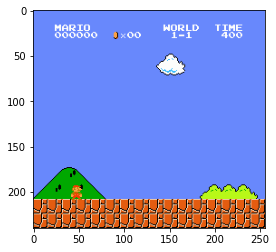

In [ ]:
# ลองสร้าง state เริ่มต้น
state = env.reset()
plt.imshow(state)
plt.show()

In [ ]:
# ทดสอบรันโดยไม่เทรน
episodes = 10
for e in range(1, episodes+1):
  env.reset()
  total_reward = 0
  done = False
  while not done:
    action = env.action_space.sample()
    next_state, reward, done, info = env.step(action)
    total_reward += reward
  print(f'episode: {e}, reward: {total_reward}, info: {info}')

/usr/local/lib/python3.7/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


episode: 1, reward: 267, info: {'coins': 0, 'flag_get': False, 'life': 2, 'score': 100, 'stage': 1, 'status': 'small', 'time': 0, 'world': 1, 'x_pos': 722, 'x_pos_screen': 79, 'y_pos': 114}
episode: 2, reward: 139, info: {'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 0, 'world': 1, 'x_pos': 594, 'x_pos_screen': 79, 'y_pos': 101}
episode: 3, reward: 137, info: {'coins': 0, 'flag_get': False, 'life': 2, 'score': 100, 'stage': 1, 'status': 'small', 'time': 0, 'world': 1, 'x_pos': 592, 'x_pos_screen': 76, 'y_pos': 79}
episode: 4, reward: 138, info: {'coins': 0, 'flag_get': False, 'life': 2, 'score': 100, 'stage': 1, 'status': 'small', 'time': 0, 'world': 1, 'x_pos': 593, 'x_pos_screen': 78, 'y_pos': 89}
episode: 5, reward: 215, info: {'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 380, 'world': 1, 'x_pos': 291, 'x_pos_screen': 112, 'y_pos': 89}
episode: 6, reward: 138, info: {'coins': 0, 'flag_get'

**Preprocessing**


``SkipFrame`` ข้ามเฟรมไป n เฟรม และในเฟรมที่ n เอา reward ของเฟรมที่ข้ามมมารวมกัน

``CropOutUnnecessary`` ตัดฉากบางส่วนออก

``GrayScale`` เปลี่ยนสี rgb เป็น gray scale

``Resize`` ลดขนาด environment ลง

``FrameStack`` เอาเฟรมที่ต่อเนื่องมารวมกันเป็น environment เดียว

``CustomReward`` สร้างระบบ

In [ ]:
class SkipFrame(gym.Wrapper):
  def __init__(self, env, skip):
    super().__init__(env)
    self._skip = skip

  def step(self, action):
    total_reward = 0.0
    done = False
    for i in range(self._skip):
        observation, reward, done, info = self.env.step(action)
        total_reward += reward
        if done:
            break
    return observation, total_reward, done, info


class CropOutUnnecessary(gym.ObservationWrapper):
  def __init__(self, env):
    super().__init__(env)
    obs_shape = (150, 200, 3)
    self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)


  def observation(self, observation):
    return observation[70:220, :200]


class GrayScale(gym.ObservationWrapper):
  def __init__(self, env):
    super().__init__(env)
    obs_shape = self.observation_space.shape[:2]
    self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

  def permute_orientation(self, observation):
    observation = np.transpose(observation, (2, 0, 1))
    observation = torch.tensor(observation.copy(), dtype=torch.float)
    return observation

  def observation(self, observation):
    observation = self.permute_orientation(observation)
    transform = T.Grayscale()
    observation = transform(observation)
    return observation


class Resize(gym.ObservationWrapper):
  def __init__(self, env, shape):
    super().__init__(env)
    self.shape = (shape, shape)

    obs_shape = self.shape + self.observation_space.shape[2:]
    self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

  def observation(self, observation):
      transforms = T.Compose(
          [T.Resize(self.shape), T.Normalize(0, 255)]
      )
      observation = transforms(observation).squeeze(0)
      return observation


class CustomReward(Wrapper):
  def __init__(self, env):
    super().__init__(env)
    self._current_score = 0

  def step(self, action):
    observation, reward, done, info = self.env.step(action)
    reward += (info['score'] - self._current_score) / 40
    self._current_score = info['score']
    if done:
      if info['flag_get']:
        reward += 150
      else:
        reward -= 100

    return observation, reward, done, info

หลังจากปรับแต่ง environment แล้ว จะอยู่ในขนาด ``(4, 64, 64)`` ซึ่งคือ 4 เฟรม ขนาด 64x64 พิกเซล



In [ ]:
def wrap_environment(env, record_every=100):
  # อัดวีดิโอทุกๆ 100 episode
  env = Monitor(
      env,
      './video',
      force=True,
      video_callable=lambda episode_id: episode_id % record_every==0
  )

  # Action ของมาริโอ้
  #   0. ไม่ทำอะไร
  #   1. ไปทางขวา
  #   2  กระโดดไปทางขวา
  #   3. วิ่งไปทางขวา
  #   4. วิ่งกระโดดไปทางขวา
  env = JoypadSpace(env, RIGHT_ONLY)
  
  env = SkipFrame(env, skip=4)
  env = CropOutUnnecessary(env)
  env = GrayScale(env)
  env = Resize(env, shape=64)
  env = FrameStack(env, num_stack=4)
  env = CustomReward(env)

  return env

# รวมตัวปรับแต่งทั้งหมดเข้ากับ environment
env = wrap_environment(env)
env.reset().shape

(4, 64, 64)

**Agent Mario**

In [ ]:
class Mario():
  def __init__(self, state_dim, action_dim, exploration_rate_decay=0.99999):
    self.state_dim = state_dim
    self.action_dim = action_dim
    self.exploration_rate = 1
    self.exploration_rate_decay = exploration_rate_decay
    self.exploration_rate_min = 0.1
    self.gamma = 0.9
    self.memory = deque(maxlen=100000)
    self.batch_size = 32
    self.memory_max = 25000
    self.learning_rate = 0.0005
    self.learn_every = 3
    self.experience_min = 50
    self.measure_step = 0
    self.cuda_available = torch.cuda.is_available()

    # Model online และ target
    self.net = DDQN(self.state_dim, self.action_dim).float()
    if self.cuda_available:
      self.net = self.net.to(device='cuda')

    self.optimizer = torch.optim.Adam(self.net.parameters(), lr=self.learning_rate)
    self.loss_function = torch.nn.SmoothL1Loss()

  def act(self, state):
    # Explore
    if self.exploration_rate > np.random.rand():
      action = np.random.randint(self.action_dim)

    # Exploit
    else:
      state = state.__array__()

      if self.cuda_available:
        state = torch.tensor(state).cuda()
      else:
        state = torch.tensor(state)

      state = state.unsqueeze(0)
      
      action = self.net(state, model='online')
      
      action = torch.argmax(action, axis=1).item()

    # ลด exploration rate
    if self.exploration_rate > self.exploration_rate_min:
      self.exploration_rate *= self.exploration_rate_decay

    self.measure_step += 1

    return action

  # ทำ Experience replay และทำการปรับค่า weight
  def learn(self):
    states, next_states, actions, rewards, done = self.recall()

    q_values = self.net(states, model='online')
    next_online_q_values = self.net(next_states, model='online')
    next_target_q_values = self.net(next_states, model='target')

    q_value = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)
    next_online_q_value = next_target_q_values.gather(1, torch.max(next_online_q_values, 1)[1].unsqueeze(1)).squeeze(1)
    expected_q_value = rewards + self.gamma * next_online_q_value * (1 - done.float())

    loss = self.loss_function(q_value, expected_q_value)
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    return loss
  
  # เก็บข้อมูลในทุกๆ action
  def remember(self, state, next_state, action, reward, done):
    state = state.__array__()
    next_state = next_state.__array__()
    
    if self.cuda_available:
      state = torch.tensor(state).cuda()
      next_state = torch.tensor(next_state).cuda()
      action = torch.tensor([action]).cuda()
      reward = torch.tensor([reward]).cuda()
      done = torch.tensor([done]).cuda()
    else:
      state = torch.tensor(state)
      next_state = torch.tensor(next_state)
      action = torch.tensor([action])
      reward = torch.tensor([reward])
      done = torch.tensor([done])

    self.memory.append((state, next_state, action, reward, done,))

  # เรียกดูข้อมูลที่เก็บไว้
  def recall(self):
    batch = random.sample(self.memory, self.batch_size)

    # ลบ memory ทิ้งเมื่อ memory เกิน memory_max เพื่อลดการใช้ RAM
    if len(self.memory) >= self.memory_max:
      self.memory.clear()

    state, next_state, action, reward, done = map(torch.stack, zip(*batch))
    return state, next_state, action.squeeze(), reward.squeeze(), done.squeeze()

  # update weight .ให้ model target
  def update_target_network(self):
    self.net.target.load_state_dict(self.net.online.state_dict())


**Duble Deep Q Network**

In [ ]:
class DDQN(nn.Module):
  def __init__(self, input_dim, output_dim):
    super().__init__()

    # conv2d x3 --> linear x2 --> output
    self.online = nn.Sequential(
        nn.Conv2d(in_channels=input_dim[0], out_channels=32, kernel_size=8, stride=4),
        nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Linear(512, output_dim),
    )

    # ก๊อปปี้ model target จาก model online
    self.target = copy.deepcopy(self.online)

    # ตั้งให้ model target ไม่เปลี่ยนแปลง
    for p in self.target.parameters():
      p.requires_grad = False

  def forward(self, input, model):
    if model == 'online':
      return self.online(input)
    elif model == 'target':
      return self.target(input)


**Analysis**

In [ ]:
class Statistic():
  def __init__(self):
    self._flags_count = 0
    self._accumulate_rewards = deque()
    self._accumulate_losses = deque()
    self._best_score = 0

  # เก็บค่าผลลัพธ์ต่างๆ
  def update(self, flag_get, reward_list, loss_list):
    new_reward = sum(reward_list)
    self._best_score = max(new_reward, self._best_score)
    self._flags_count += flag_get
    self._accumulate_rewards.append(new_reward)
    if loss_list:
      self._accumulate_losses.append(sum(loss_list) / len(loss_list))

  def average_score(self):
    return sum(self._accumulate_rewards) / len(self._accumulate_rewards)

  def average_loss(self):
    return sum(self._accumulate_losses) / len(self._accumulate_losses)

  def __str__(self):
    return f'Best score: {self._best_score}\nAverage score: {self.average_score()}\nTotal flags count: {self._flags_count}\nAverage loss: {self.average_loss()}'

  # พล็อตกราฟ
  def plot_stat(self):
    plt.figure(1, figsize=(22, 15))

    plt.subplot(211)
    plt.plot(self._accumulate_rewards)
    plt.grid()
    plt.title('Reward per episode')
    plt.xlabel('Episode')
    plt.ylabel('Reward')

    plt.subplot(212)
    plt.plot(self._accumulate_losses)
    plt.title('Loss per episode')
    plt.grid()
    plt.xlabel('Episode')
    plt.ylabel('Loss')

    plt.show()


**สร้าง Agent และ Analyzer**

In [ ]:
MAiRO = Mario(state_dim=(4, 64, 64), action_dim=env.action_space.n)
analyzer = Statistic()
MAiRO.net

DDQN(
  (online): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=1024, out_features=512, bias=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=5, bias=True)
  )
  (target): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=1024, out_features=512, bias=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=5, bias=True)
  )
)

**Load Trained Params**

In [ ]:
# โหลด model ที่เทรนไปแล้ว
if torch.cuda.is_available():
  MAiRO.net.online.load_state_dict(torch.load('./trained_parameters'))
  MAiRO.net.target.load_state_dict(torch.load('./trained_parameters'))
else:
  MAiRO.net.online.load_state_dict(torch.load('./trained_parameters', map_location=torch.device('cpu')))
  MAiRO.net.target.load_state_dict(torch.load('./trained_parameters', map_location=torch.device('cpu')))

**Start Training**

In [ ]:
episodes = 3000
line = '='*125
for e in range(1, episodes+1):
  state = env.reset()
  total_rewards = []
  total_losses = []
  while True:

    # Get action
    action = MAiRO.act(state)

    # Get reward
    next_state, reward, done, info = env.step(action)

    # Remember
    MAiRO.remember(state, next_state, action, reward, done)

    # Learn every 3 actions taken and do action more than 50 times
    # เรียนทุกๆ 3 action และเมื่อทำ action ไปแล้วมากกว่า 50 ครั้ง
    if len(MAiRO.memory) > MAiRO.experience_min:
      if MAiRO.measure_step % MAiRO.learn_every == 0:
        loss = MAiRO.learn()

        # Record loss
        total_losses.append(loss)

    # Update state
    state = next_state

    # Record reward
    total_rewards.append(reward)

    # เช็คว่าเกมจบหรือยัง
    if done or info['flag_get']:
      break

  # อัพเดต target ทุกๆ episode จบ
  MAiRO.update_target_network()

  # ได้ธงหรือเปล่า
  if info['flag_get']:
    flag = 'Yes!!!'
  else:
    flag = 'No...'

  # วิเคราะห์ผลลัพธ์
  analyzer.update(info['flag_get'], total_rewards, total_losses)

  if e%100 == 0 or e == 1:
    print(line)
    print(f'Episode: {e}/{episodes}, Score: {sum(total_rewards)}, Epsilon: {round(MAiRO.exploration_rate, 5)}, Flag: {flag}, Time: {datetime.datetime.now().strftime("%x %X")}')
    print(line)
    print()

/usr/local/lib/python3.7/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode: 1/3000, Score: 622.5, Epsilon: 0.99358, Flag: No..., Time: 11/28/21 03:39:16



/usr/local/lib/python3.7/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode: 100/3000, Score: 528.5, Epsilon: 0.76163, Flag: No..., Time: 11/28/21 03:45:02



/usr/local/lib/python3.7/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode: 200/3000, Score: 671.5, Epsilon: 0.6383, Flag: No..., Time: 11/28/21 03:48:58



/usr/local/lib/python3.7/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode: 300/3000, Score: 503.0, Epsilon: 0.53179, Flag: No..., Time: 11/28/21 03:53:08



/usr/local/lib/python3.7/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode: 400/3000, Score: 508.0, Epsilon: 0.43653, Flag: No..., Time: 11/28/21 03:57:43



/usr/local/lib/python3.7/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode: 500/3000, Score: 1584.5, Epsilon: 0.37046, Flag: No..., Time: 11/28/21 04:01:37



/usr/local/lib/python3.7/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode: 600/3000, Score: 482.0, Epsilon: 0.32065, Flag: No..., Time: 11/28/21 04:05:12



/usr/local/lib/python3.7/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode: 700/3000, Score: 147.0, Epsilon: 0.27454, Flag: No..., Time: 11/28/21 04:08:57



/usr/local/lib/python3.7/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode: 800/3000, Score: 151.0, Epsilon: 0.23834, Flag: No..., Time: 11/28/21 04:12:21



/usr/local/lib/python3.7/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode: 900/3000, Score: 704.0, Epsilon: 0.20495, Flag: No..., Time: 11/28/21 04:16:03



/usr/local/lib/python3.7/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode: 1000/3000, Score: 713.0, Epsilon: 0.18149, Flag: No..., Time: 11/28/21 04:19:03



/usr/local/lib/python3.7/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode: 1100/3000, Score: 554.0, Epsilon: 0.15773, Flag: No..., Time: 11/28/21 04:22:30



/usr/local/lib/python3.7/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode: 1200/3000, Score: 1226.5, Epsilon: 0.14005, Flag: No..., Time: 11/28/21 04:25:29



/usr/local/lib/python3.7/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode: 1300/3000, Score: 548.0, Epsilon: 0.1185, Flag: No..., Time: 11/28/21 04:29:38



/usr/local/lib/python3.7/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode: 1400/3000, Score: 544.0, Epsilon: 0.10512, Flag: No..., Time: 11/28/21 04:32:38



/usr/local/lib/python3.7/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode: 1500/3000, Score: 145.0, Epsilon: 0.1, Flag: No..., Time: 11/28/21 04:35:32



/usr/local/lib/python3.7/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode: 1600/3000, Score: 1334.5, Epsilon: 0.1, Flag: No..., Time: 11/28/21 04:38:49



/usr/local/lib/python3.7/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode: 1700/3000, Score: 1833.5, Epsilon: 0.1, Flag: No..., Time: 11/28/21 04:42:23



/usr/local/lib/python3.7/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode: 1800/3000, Score: 957.0, Epsilon: 0.1, Flag: No..., Time: 11/28/21 04:46:09



/usr/local/lib/python3.7/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode: 1900/3000, Score: 943.0, Epsilon: 0.1, Flag: No..., Time: 11/28/21 04:49:31



/usr/local/lib/python3.7/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode: 2000/3000, Score: 1847.0, Epsilon: 0.1, Flag: No..., Time: 11/28/21 04:53:08



/usr/local/lib/python3.7/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode: 2100/3000, Score: 152.0, Epsilon: 0.1, Flag: No..., Time: 11/28/21 04:56:51



/usr/local/lib/python3.7/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode: 2200/3000, Score: 1612.0, Epsilon: 0.1, Flag: No..., Time: 11/28/21 05:00:27



/usr/local/lib/python3.7/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode: 2300/3000, Score: 138.0, Epsilon: 0.1, Flag: No..., Time: 11/28/21 05:04:09



/usr/local/lib/python3.7/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode: 2400/3000, Score: 931.0, Epsilon: 0.1, Flag: No..., Time: 11/28/21 05:08:20



/usr/local/lib/python3.7/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode: 2500/3000, Score: 1336.5, Epsilon: 0.1, Flag: No..., Time: 11/28/21 05:12:11



/usr/local/lib/python3.7/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode: 2600/3000, Score: 1807.5, Epsilon: 0.1, Flag: No..., Time: 11/28/21 05:16:40



/usr/local/lib/python3.7/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode: 2700/3000, Score: 1241.0, Epsilon: 0.1, Flag: No..., Time: 11/28/21 05:20:21



/usr/local/lib/python3.7/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode: 2800/3000, Score: 526.5, Epsilon: 0.1, Flag: No..., Time: 11/28/21 05:26:26



/usr/local/lib/python3.7/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode: 2900/3000, Score: 520.0, Epsilon: 0.1, Flag: No..., Time: 11/28/21 05:30:17



/usr/local/lib/python3.7/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode: 3000/3000, Score: 944.0, Epsilon: 0.1, Flag: No..., Time: 11/28/21 05:34:11



# **Result and Discussion**

**วิเคราะห์**

In [ ]:
print(analyzer)

Best score: 3236.5
Average score: 877.7016666666667
Total flags count: 18
Average loss: 4.435542131608277


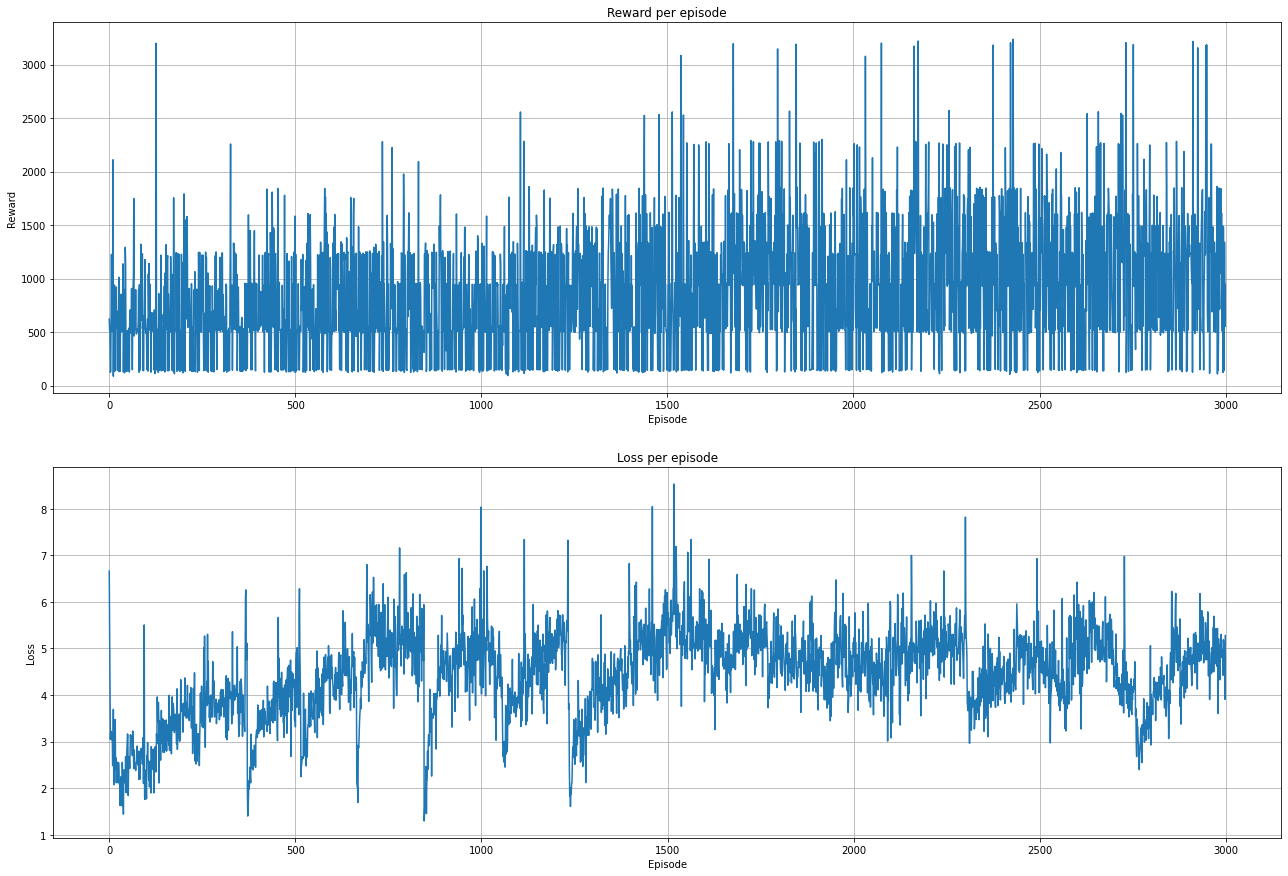

In [ ]:
analyzer.plot_stat()

**Save Parameters**

In [ ]:
torch.save(MAiRO.net.online.state_dict(), './trained_parameters')

**ทดสอบรัน model กับ environment ที่ต่างกัน 4 อัน**

In [ ]:
env_1_1 = gym_super_mario_bros.make("SuperMarioBros-1-1-v0")
env_1_2 = gym_super_mario_bros.make("SuperMarioBros-1-2-v0")
env_1_3 = gym_super_mario_bros.make("SuperMarioBros-1-3-v0")
env_1_4 = gym_super_mario_bros.make("SuperMarioBros-1-4-v0")

state_1_1 = env_1_1.reset()
state_1_2 = env_1_2.reset()
state_1_3 = env_1_3.reset()
state_1_4 = env_1_4.reset()

**ตัวอย่าง environment ทั้ง 4 อัน**

Text(0.5, 1.0, 'World 1-4')

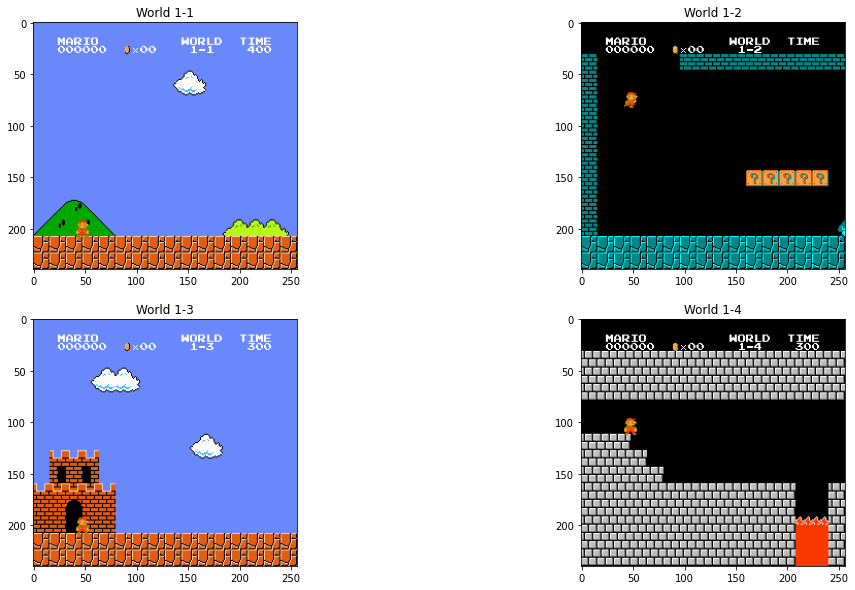

In [ ]:
plt.figure(1, figsize=(18, 10))

plt.subplot(221)
plt.imshow(state_1_1)
plt.title('World 1-1')

plt.subplot(222)
plt.imshow(state_1_2)
plt.title('World 1-2')

plt.subplot(223)
plt.imshow(state_1_3)
plt.title('World 1-3')

plt.subplot(224)
plt.imshow(state_1_4)
plt.title('World 1-4')

In [ ]:
env_1_1 = wrap_environment(env_1_1, record_every=10)
env_1_2 = wrap_environment(env_1_2, record_every=10)
env_1_3 = wrap_environment(env_1_3, record_every=10)
env_1_4 = wrap_environment(env_1_4, record_every=10)

World 1-1

In [ ]:
episodes = 10

for e in range(1, episodes+1):
  state = env_1_1.reset()
  total_reward = 0
  while True:
    action = MAiRO.act(state)
    next_state, reward, done, info = env_1_1.step(action)
    state = next_state
    total_reward += reward
    if done:
      break

  if info['flag_get']:
    flag = 'YES!!!'
    flag_count += 1
  else:
    flag = 'No...'
  
  print(f'Episode: {e}, Score: {total_reward}, Distance: {info["x_pos"]}, Flag: {flag}, {datetime.datetime.now().strftime("%x %X")}')

/usr/local/lib/python3.7/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode: 1, Score: 156.0, Distance: 314, Flag: No..., 11/28/21 05:50:51
Episode: 2, Score: 1609.0, Distance: 1793, Flag: No..., 11/28/21 05:50:53
Episode: 3, Score: 1589.0, Distance: 1783, Flag: No..., 11/28/21 05:50:55
Episode: 4, Score: 1597.5, Distance: 1800, Flag: No..., 11/28/21 05:50:58
Episode: 5, Score: 1756.5, Distance: 1958, Flag: No..., 11/28/21 05:51:00
Episode: 6, Score: 1469.5, Distance: 1664, Flag: No..., 11/28/21 05:51:02
Episode: 7, Score: 1776.0, Distance: 1955, Flag: No..., 11/28/21 05:51:04
Episode: 8, Score: 128.5, Distance: 308, Flag: No..., 11/28/21 05:51:05
Episode: 9, Score: 1693.5, Distance: 2226, Flag: No..., 11/28/21 05:51:27
Episode: 10, Score: 602.0, Distance: 801, Flag: No..., 11/28/21 05:51:28


World 1-2

In [ ]:
episodes = 10

for e in range(1, episodes+1):
  state = env_1_2.reset()
  total_reward = 0
  while True:
    action = MAiRO.act(state)
    next_state, reward, done, info = env_1_2.step(action)
    state = next_state
    total_reward += reward
    if done:
      break

  if info['flag_get']:
    flag = 'YES!!!'
    flag_count += 1
  else:
    flag = 'No...'
  
  print(f'Episode: {e}, Score: {total_reward}, Distance: {info["x_pos"]}, Flag: {flag}, Time: {datetime.datetime.now().strftime("%x %X")}')

/usr/local/lib/python3.7/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode: 1, Score: 633.0, Distance: 850, Flag: No..., Time: 11/28/21 05:51:40
Episode: 2, Score: 502.5, Distance: 672, Flag: No..., Time: 11/28/21 05:51:42
Episode: 3, Score: 662.5, Distance: 852, Flag: No..., Time: 11/28/21 05:51:44
Episode: 4, Score: -203.5, Distance: 354, Flag: No..., Time: 11/28/21 05:52:07
Episode: 5, Score: -201.0, Distance: 354, Flag: No..., Time: 11/28/21 05:52:29
Episode: 6, Score: 39.5, Distance: 208, Flag: No..., Time: 11/28/21 05:52:30
Episode: 7, Score: -193.5, Distance: 354, Flag: No..., Time: 11/28/21 05:52:52
Episode: 8, Score: 747.0, Distance: 933, Flag: No..., Time: 11/28/21 05:52:54
Episode: 9, Score: -196.0, Distance: 354, Flag: No..., Time: 11/28/21 05:53:17
Episode: 10, Score: 674.5, Distance: 852, Flag: No..., Time: 11/28/21 05:53:18


World 1-3

In [ ]:
episodes = 10

for e in range(1, episodes+1):
  state = env_1_3.reset()
  total_reward = 0
  while True:
    action = MAiRO.act(state)
    next_state, reward, done, info = env_1_3.step(action)
    state = next_state
    total_reward += reward
    if done:
      break

  if info['flag_get']:
    flag = 'YES!!!'
    flag_count += 1
  else:
    flag = 'No...'
  
  print(f'Episode: {e}, Score: {total_reward}, Distance: {info["x_pos"]}, Flag: {flag}, Time: {datetime.datetime.now().strftime("%x %X")}')

/usr/local/lib/python3.7/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode: 1, Score: 151.0, Distance: 314, Flag: No..., Time: 11/28/21 05:53:21
Episode: 2, Score: 150.0, Distance: 313, Flag: No..., Time: 11/28/21 05:53:21
Episode: 3, Score: 151.0, Distance: 314, Flag: No..., Time: 11/28/21 05:53:22
Episode: 4, Score: 154.0, Distance: 317, Flag: No..., Time: 11/28/21 05:53:22
Episode: 5, Score: 136.0, Distance: 299, Flag: No..., Time: 11/28/21 05:53:22
Episode: 6, Score: 151.0, Distance: 314, Flag: No..., Time: 11/28/21 05:53:23
Episode: 7, Score: 152.0, Distance: 315, Flag: No..., Time: 11/28/21 05:53:23
Episode: 8, Score: 124.0, Distance: 285, Flag: No..., Time: 11/28/21 05:53:23
Episode: 9, Score: 256.0, Distance: 422, Flag: No..., Time: 11/28/21 05:53:24
Episode: 10, Score: 151.0, Distance: 314, Flag: No..., Time: 11/28/21 05:53:24


World 1-4

In [ ]:
episodes = 10

for e in range(1, episodes+1):
  state = env_1_4.reset()
  total_reward = 0
  while True:
    action = MAiRO.act(state)
    next_state, reward, done, info = env_1_4.step(action)
    state = next_state
    total_reward += reward
    if done:
      break

  if info['flag_get']:
    flag = 'YES!!!'
    flag_count += 1
  else:
    flag = 'No...'
  
  print(f'Episode: {e}, Score: {total_reward}, Distance: {info["x_pos"]}, Flag: {flag}, Time: {datetime.datetime.now().strftime("%x %X")}')

Episode: 1, Score: 71.0, Distance: 232, Flag: No..., Time: 11/28/21 05:53:28
Episode: 2, Score: 71.0, Distance: 234, Flag: No..., Time: 11/28/21 05:53:29
Episode: 3, Score: 71.0, Distance: 232, Flag: No..., Time: 11/28/21 05:53:29
Episode: 4, Score: 70.0, Distance: 231, Flag: No..., Time: 11/28/21 05:53:30
Episode: 5, Score: 71.0, Distance: 232, Flag: No..., Time: 11/28/21 05:53:30
Episode: 6, Score: 71.0, Distance: 232, Flag: No..., Time: 11/28/21 05:53:30


/usr/local/lib/python3.7/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode: 7, Score: 272.0, Distance: 440, Flag: No..., Time: 11/28/21 05:53:31
Episode: 8, Score: 69.0, Distance: 230, Flag: No..., Time: 11/28/21 05:53:31
Episode: 9, Score: 71.0, Distance: 233, Flag: No..., Time: 11/28/21 05:53:32
Episode: 10, Score: 270.0, Distance: 437, Flag: No..., Time: 11/28/21 05:53:32


# **Conclusion**

เนื่องจากหากจะทำให้มาริโอ้วิ่งถึงธงหรือสิ้นสุดด่าน จำเป็นต้องใช้ episode ที่มหาศาล แต่ด้วยทรัพยากรที่จำกัดทำให้สามารถเทรนได้ผลลัพธ์ที่อยู่ในช่วงไม่สูงมาก ถ้าได้รันอย่างน้อย 20,000 episodes อาจจะได้ผลลัพธ์ที่พึงพอใจออกมาได้

# **References**

[1] https://pypi.org/project/gym-super-mario-bros/

[2] https://github.com/fschur/DDQN-with-PyTorch-for-OpenAI-Gym

[3] https://colab.research.google.com/drive/1eN33dPVtdPViiS1njTW_-r-IYCDTFU7N

[4] https://github.com/yuansongFeng/MadMario/

[5] https://pytorch.org/